# 특수 회귀

이번 시간에는 Lasso, PLS regression을 실습하겠습니다.

## 데이터 불러오기

In [141]:
import pandas as pd
import numpy as np

In [142]:
from sklearn.datasets import make_regression

In [143]:
# 데이터 불러오기
X, y, true_coef = make_regression(n_samples=100, n_features=100, n_informative = 10, coef= True)
# 100개 샘플
# 100개 피쳐
# 실제로 중요한 피쳐 10개

In [144]:
import matplotlib.pyplot as plt

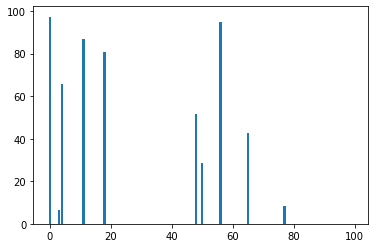

In [145]:
plt.bar(np.arange(len(true_coef)),true_coef)
plt.show()

## Remark!

Lasso 와 PLS regression 모두 hyper-parameter에 대한 tuning 을 해주어야 합니다.     
따라서 데이터를 train-validation-test 로 나눠서 모델을 학습 및 평가하도록 하겠습니다.   
이 때 Hyper-parameter 최적화에 GridSearchCV 라는 패키지를 사용하도록 하겠습니다.

![CV](./cvtest.png)

### Grid search    
grid search는 hyper-parameter를 아래 그림과 같이 일정한 간격으로 나누어 각각의 경우의 수를 평가하고 최적 hyper-parameter를 결정하는 알고리즘입니다. (이 때 hyper parameter는사람이 결정할 수 있는 변수라고 이해하셔도 좋습니다.)     
본 챕터에서는 학습 데이터를 training, validation, test data로 분할하고, training, validation data를 사용해서 최적 hyper-parameter를 구하고, 최종 모델 평가를 위해 test data를 사용하도록 하겠습니다.

![CV](./gridsearch.png)

In [146]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [147]:
# cross validation 
from sklearn.model_selection import GridSearchCV, RepeatedKFold

또한, solution을 opimize 하는 과정에서 정규화된 variable을 사용하므로 다음 라이브러리를 사용해서 
독립 변수들을 정규화 하도록 하겠습니다.

In [148]:
from sklearn.preprocessing import StandardScaler

## 참고: Linear regression 

In [149]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_hat_lr)

In [150]:
mse_lr

12341.93331680864

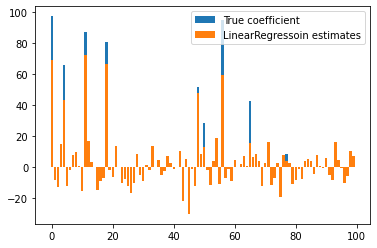

In [151]:
p1 = plt.bar(np.arange(len(true_coef)),true_coef)
p2 = plt.bar(np.arange(len(true_coef)),lr.coef_)
plt.legend((p1[0],p2[0]), ('True coefficient','LinearRegressoin estimates'))
plt.show()

## Lasso 

In [152]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path
from itertools import cycle

In [153]:
# 변수를 정규화시키도록 하겠습니다. 
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data = X_train_scaled)

정규화 수식은 다음과 같습니다.    
$X^{std} = \frac{X-E(X)}{\sigma(X)}$

In [154]:
# cross validation을 사용해서 hyper parameter를 tunning함.
# cross validation을 어떻게 진행할 것인지에 대한 정보를 줍니다.
# 이 경우 n_splits (number of folds) = 10, n_repeats = cross validatoin 반복 횟수 = 3
# 즉, k = 10 cross validation 을 3 번 반복합니다.
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [155]:
# cv가 어떻게 되는 지 n_split 과 n_repeat 을 바꿔가며 확인해보세요...!
X_sample = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y_sample = np.array([0, 0, 1, 1])
rkf = RepeatedKFold(n_splits=2, n_repeats=1)
for train_index, test_index in rkf.split(X_sample):
     print("TRAIN:", train_index, "TEST:", test_index)
#      X_train, X_test = X_sample[train_index], X_sample[test_index]
#      y_train, y_test = y_sample[train_index], y_sample[test_index]

TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]


In [156]:
# Hyper parameter 후보 정하기.
lasso_alphas = np.linspace(0, 0.2, 21) # 0 ~ 0.2 사이는 21 등분한 alpha를 후보로 사용.
lasso = Lasso()

grid = dict()
grid['alpha'] = lasso_alphas

# Hyper parameter tunning.
# estimator = lasso
# grid = hyper parameter 후보!
# scoring = 모델 평가 기준
# cv = 위에서 정의한 cv 기준을 넣어줍니다.
gscv = GridSearchCV(lasso, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
results = gscv.fit(X_train_scaled, y_train)

print('MAE: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.10255
Config: {'alpha': 0.03}


In [157]:
# train lasso with the best param
# results.best_estimator_ 를 이용해도 되지만 전체 training data 를 사용해서 최종 모델을 만들도록 하겠습니다.
lasso = Lasso(alpha = 0.03)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.03)

In [158]:
# 정규화된 변수에 대해 학습한 모델을 사용하므로
# X_test 또한 정규화 시켜줍니다.
X_test_scaled = sc.transform(X_test)
y_hat = lasso.predict(X_test_scaled)

In [159]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_hat)

0.016336592363302767

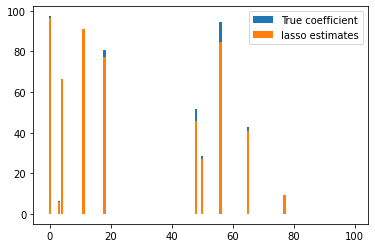

In [160]:
p1 = plt.bar(np.arange(len(true_coef)),true_coef)
p2 = plt.bar(np.arange(len(true_coef)),lasso.coef_)
plt.legend((p1[0],p2[0]), ('True coefficient','lasso estimates'))
plt.show()

## PLS

In [161]:
from sklearn.cross_decomposition import PLSRegression

In [162]:
# Standardize the data.
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data = X_train_scaled)

In [163]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Hyper-parameter 후보 설정.
pls_n_components = np.arange(1, 101) # 1 ~ 100

# 모델 선언
pls = PLSRegression()

# GridSearchCV() 함수 인자로 주기 위해서
# Hyper-parameter 후보를 dictionary 에 저장
grid = dict()
grid['n_components'] = pls_n_components

 # Hyper parameter tunning.
gscv = GridSearchCV(pls, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
results = gscv.fit(X_train_scaled, y_train)

print('MAE: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -106.12979
Config: {'n_components': 29}


In [165]:
# 모델 선언
pls = PLSRegression(n_components= 29)
pls.fit(X_train_scaled, y_train)

PLSRegression(n_components=29)

In [166]:
X_test_scaled = sc.transform(X_test)
y_hat = pls.predict(X_test_scaled)

In [167]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_hat)

10417.691925741772

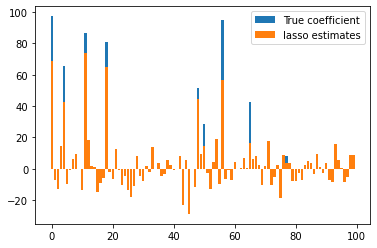

In [168]:
p1 = plt.bar(np.arange(len(true_coef)),true_coef)
p2 = plt.bar(np.arange(len(true_coef)),pls.coef_.flatten())
plt.legend((p1[0],p2[0]), ('True coefficient','lasso estimates'))
plt.show()

---

## 실습: Boston data 

In [85]:
boston = pd.read_csv('./Boston_house.csv')

In [86]:
boston.head()

,AGE,B,RM,CRIM,DIS,INDUS,LSTAT,NOX,PTRATIO,RAD,ZN,TAX,CHAS,Target
0,65.2,396.90,6.575,0.00632,4.0900,2.31,4.98,0.538,15.3,1,18.0,296,0,24.0
1,78.9,396.90,6.421,0.02731,4.9671,7.07,9.14,0.469,17.8,2,0.0,242,0,21.6
2,61.1,392.83,7.185,0.02729,4.9671,7.07,4.03,0.469,17.8,2,0.0,242,0,34.7
3,45.8,394.63,6.998,0.03237,6.0622,2.18,2.94,0.458,18.7,3,0.0,222,0,33.4
4,54.2,396.90,7.147,0.06905,6.0622,2.18,5.33,0.458,18.7,3,0.0,222,0,36.2


## Train-test split

In [87]:
X, y = boston[boston.columns.drop('Target')], boston[['Target']]

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

### Lasso 

In [ ]:
# 데이터 정규화


# model 선언

# cross validation을 사용해서 hyper parameter를 tunning할 준비


# hyper parameter tunning

In [ ]:
# 최종 모델 결정

In [ ]:
# model performance 출력

### 실습 가이드

In [91]:
# 데이터 정규화
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data = X_train_scaled)

In [92]:
# model 선언
lasso = Lasso()

In [94]:
# cross validation을 사용해서 hyper parameter를 tunning할 준비
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = np.linspace(0, 0.2, 21) # 0 ~ 0.2 사이는 21 등분한 alpha를 후보로 사용.
grid = dict()
grid['alpha'] = lasso_alphas

In [95]:
# hyper parameter tunning
gscv = GridSearchCV(lasso, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
results = gscv.fit(X_train_scaled, y_train)

In [96]:
print('MAE: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -3.29916
Config: {'alpha': 0.03}


In [99]:
# 최종 모델 결정
# train lasso with the best param
# results.best_estimator_ 를 이용해도 되지만 전체 training data 를 사용해서 최종 모델을 만들도록 하겠습니다.
lasso = Lasso(alpha = 0.03)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.03)

In [108]:
# model performance 
X_test_scaled = sc.transform(X_test)
y_hat = lasso.predict(X_test_scaled)
mean_squared_error(y_test, y_hat)

19.929168472064276

### PLS regression

In [ ]:
# 데이터 정규화


# model 선언

# cross validation을 사용해서 hyper parameter를 tunning할 준비


# hyper parameter tunning

In [ ]:
# 최종 모델 결정

In [ ]:
# model performance 출력

### 실습 가이드

In [110]:
# 데이터 정규화
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data = X_train_scaled)

In [111]:
# model 선언
pls = PLSRegression()

In [109]:
# cross validation을 사용해서 hyper parameter를 tunning할 준비
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

n_components = np.arange(1, X_train.shape[1]+1) # 1 <= n_components <= X.shape[1] 
grid = dict()
grid['n_components'] = n_components

In [113]:
# hyper parameter tunning
gscv = GridSearchCV(pls, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
results = gscv.fit(X_train_scaled, y_train)

In [114]:
print('MAE: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -3.54272
Config: {'n_components': 8}


In [115]:
# 최종 모델 결정
# train PLS with the best param
# results.best_estimator_ 를 이용해도 되지만 전체 training data 를 사용해서 최종 모델을 만들도록 하겠습니다.
pls = PLSRegression(n_components = 8)
pls.fit(X_train_scaled, y_train)

PLSRegression(n_components=8)

In [123]:
print(f'dimension of X: {X_train.shape[1]}')
print(f'the optimal number of latent variables: 8')

dimension of X: 13
the optimal number of latent variables: 8


In [126]:
# model performance 
X_test_scaled = sc.transform(X_test)
y_hat = pls.predict(X_test_scaled)
mean_squared_error(y_test, y_hat)

20.692898261831445